In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import json
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from model import MoleculeACEDataset
from preprocessing import preprocess_data

In [2]:
df_train = pd.read_csv("../data/df_train.csv")

df_train.head()

,smiles,exp_mean [nM],y,cliff_mol,split,y [pEC50/pKi],active,ecfp,cliff_mol_binary,similar_molecules
0,CN1C2CCC1CC(OC(c1ccc(F)cc1)c1ccc(F)cc1)C2,145.0,-2.161368,0,train,6.838632,0,"[-0.06217700042172756, 3.0942948523831184, -0....",1,"[10, 20, 2020]"
1,c1ccc(N2CCN(CCCn3c4ccccc4c4ccccc43)CC2)cc1,2420.0,-3.383815,0,train,5.616185,0,"[-0.06217700042172756, -0.3231754075504108, -0...",0,[]
2,O=C(NCCCN1CCN(c2ccccc2)CC1)c1cccc2c1-c1ccccc1C2=O,430.0,-2.633468,0,train,6.366532,0,"[-0.06217700042172756, 3.0942948523831184, -0....",0,[26]
3,O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc2c(c1)-...,0.9,0.045757,1,train,9.045757,1,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[4, 5, 7, 526, 586, 1281, 1590]"
4,O=C(NCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cccc2c1Cc1c...,170.0,-2.230449,1,train,6.769551,0,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[3, 7, 526]"


In [3]:
def get_cliff_groups(df):
    group_dict = dict()
    next_group_idx = 0
    group_indices = []

    for i, similar_molecules in enumerate(df['similar_molecules']):
        similar_molecules = ast.literal_eval(similar_molecules)
        # non-cliff molecules:
        if len(similar_molecules) == 0 or df['cliff_mol_binary'][i] == 0:
            group_indices.append(-1)
            continue

        # cliff molecules:
        for j in range(0, next_group_idx):  # keys already in dictionary
            if i in group_dict[j]:
                group_indices.append(j)
                group_dict[j].update(similar_molecules)
                break

        if len(group_indices) != i + 1:  # no group index set yet
            group_dict[next_group_idx] = set(similar_molecules)
            group_indices.append(next_group_idx)
            next_group_idx += 1

    return merge_overlapping_sets(group_dict)

def merge_overlapping_sets(group_dict):
    keys = list(group_dict.keys())
    merged_sets = []

    for key in keys:
        merged = False
        for m_set in merged_sets:
            if not group_dict[key].isdisjoint(m_set):
                m_set.update(group_dict[key])
                merged = True
                break
        if not merged:
            merged_sets.append(group_dict[key])

    # reassign merged sets to a new dictionary with sequential keys
    merged_dict = {idx: merged_set for idx, merged_set in enumerate(merged_sets)}

    return merged_dict

In [4]:
# TODO: careful - we are using train molecules here. for validation and test set, 
# there would only be one activity cliff group

In [5]:
group_dict = get_cliff_groups(df_train)
group_map = {idx: key for key, indices in group_dict.items() for idx in indices}
df_train['cliff_group'] = df_train.index.map(group_map)
df_train = df_train.dropna(subset=['cliff_group'])
df_train['cliff_group'] = df_train['cliff_group'].astype(int)

df_train.head()

,smiles,exp_mean [nM],y,cliff_mol,split,y [pEC50/pKi],active,ecfp,cliff_mol_binary,similar_molecules,cliff_group
0,CN1C2CCC1CC(OC(c1ccc(F)cc1)c1ccc(F)cc1)C2,145.0,-2.161368,0,train,6.838632,0,"[-0.06217700042172756, 3.0942948523831184, -0....",1,"[10, 20, 2020]",0
3,O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc2c(c1)-...,0.9,0.045757,1,train,9.045757,1,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[4, 5, 7, 526, 586, 1281, 1590]",1
4,O=C(NCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cccc2c1Cc1c...,170.0,-2.230449,1,train,6.769551,0,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[3, 7, 526]",1
5,O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc2c(c1)-...,1.4,-0.146128,1,train,8.853872,1,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[3, 7, 526, 586, 1281, 1590]",1
7,O=C(NCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1ccc2c(c1)Cc...,110.0,-2.041393,1,train,6.958607,0,"[-0.06217700042172756, -0.3231754075504108, -0...",1,"[3, 4, 5, 526, 586, 1281, 1288]",1


In [6]:
network_baseline = torch.load('../models/baseline_mlp.pt', weights_only=False)
network_baseline = network_baseline.to(torch.device("cpu"))
network_manhattan = torch.load('../models/mlp_triplet_manhattan.pt', weights_only=False)
network_manhattan = network_manhattan.to(torch.device("cpu"))
network_cosine = torch.load('../models/mlp_triplet_cosine.pt', weights_only=False)
network_cosine = network_cosine.to(torch.device("cpu"))

networks = [network_baseline, network_manhattan, network_cosine]
network_titles = ["MLP BCE", "MLP Manhattan", "MLP Cosine"]


In [7]:
data = np.zeros((3, len(group_dict), 8))

for i, network in enumerate(networks):
    def str_to_array(x):
        return np.array(json.loads(x), dtype=np.float32)

    for group_id, group_data in df_train.groupby('cliff_group'):
        percentage_active = np.sum(group_data['active']) / len(group_data)

        network.eval()
        dataset = MoleculeACEDataset(group_data['ecfp'].apply(str_to_array), group_data['active'])
        data_loader = DataLoader(dataset, batch_size=len(group_data))

        samples, targets = next(iter(data_loader))
        assert len(samples) == len(group_data)

        outputs, emb = network(samples)

        probabilities = torch.sigmoid(outputs)
        roc_auc = roc_auc_score(targets.detach().numpy(), probabilities.detach().numpy())

        bce_loss = nn.BCEWithLogitsLoss()(outputs.squeeze(), targets)

        min_dist_manhattan = np.inf
        max_dist_manhattan = -np.inf
        min_dist_cosine = np.inf
        max_dist_cosine= -np.inf

        for idx_i in range(len(emb)):
            emb_i = emb[idx_i].unsqueeze(0)
            
            for idx_j in range(idx_i + 1, len(emb)):
                emb_j = emb[idx_j].unsqueeze(0)

                if targets[idx_i] == targets[idx_j]:
                    continue

                manhattan_dist = torch.cdist(emb_i, emb_j, p=1).detach().numpy().item() 
                cosine_dist = nn.functional.cosine_similarity(emb_i, emb_j).detach().numpy().item()

                if manhattan_dist < min_dist_manhattan:
                    min_dist_manhattan = manhattan_dist
                if manhattan_dist > max_dist_manhattan:
                    max_dist_manhattan = manhattan_dist
                if cosine_dist < min_dist_cosine:
                    min_dist_cosine = cosine_dist
                if cosine_dist > max_dist_cosine:
                    max_dist_cosine = cosine_dist

        data[i, group_id, 0] = percentage_active
        data[i, group_id, 1] = roc_auc
        data[i, group_id, 2] = bce_loss
        data[i, group_id, 3] = len(group_data)
        data[i, group_id, 4] = min_dist_manhattan
        data[i, group_id, 5] = max_dist_manhattan
        data[i, group_id, 6] = min_dist_cosine
        data[i, group_id, 7] = max_dist_cosine

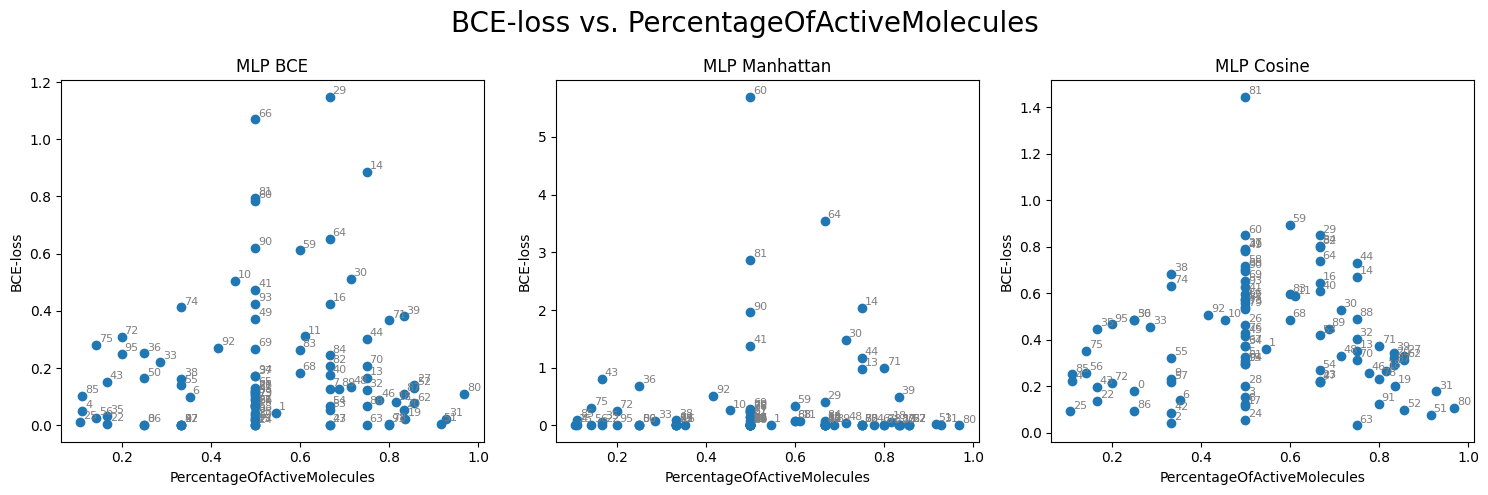

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, network in enumerate(networks):
    axes[i].scatter(data[i, :, 0], data[i, :, 2])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("PercentageOfActiveMolecules")
    axes[i].set_ylabel("BCE-loss")

    for j in range(data.shape[1]):
        axes[i].annotate(
            str(j),  
            (data[i, j, 0], data[i, j, 2]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=8,
            color="grey"
        )

fig.suptitle("BCE-loss vs. PercentageOfActiveMolecules", fontsize=20)

plt.tight_layout()
plt.show()

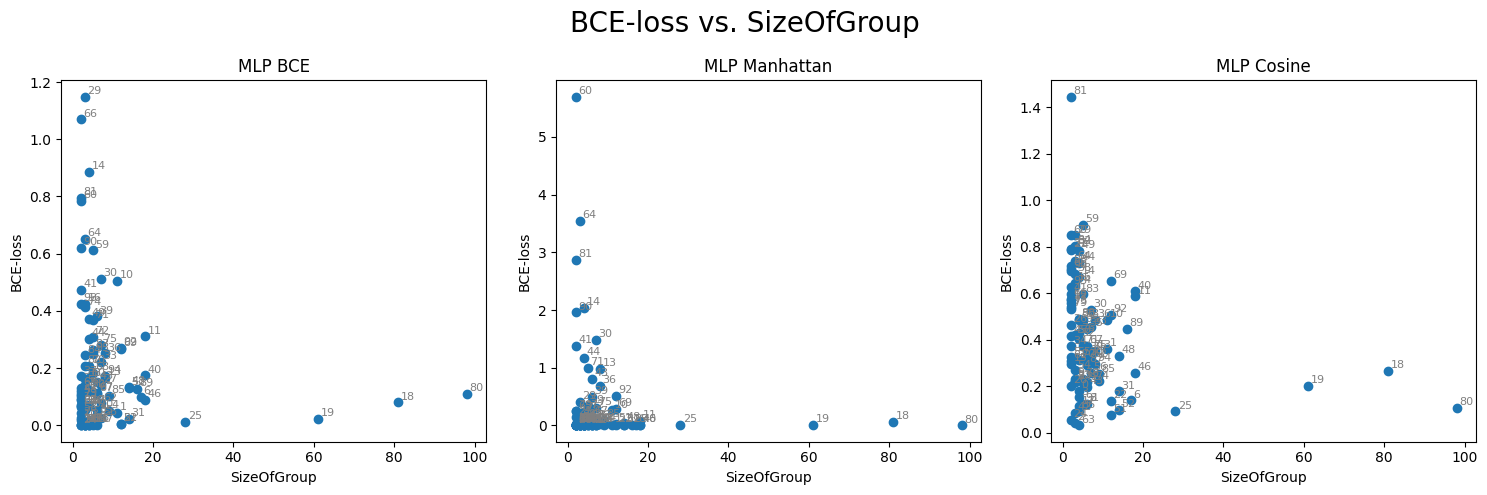

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, network in enumerate(networks):
    axes[i].scatter(data[i, :, 3], data[i, :, 2])
    axes[i].set_title(network_titles[i])
    axes[i].set_xlabel("SizeOfGroup")
    axes[i].set_ylabel("BCE-loss")

    for j in range(data.shape[1]):
        axes[i].annotate(
            str(j),  
            (data[i, j, 3], data[i, j, 2]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=8,
            color="grey"
        )

fig.suptitle("BCE-loss vs. SizeOfGroup", fontsize=20)

plt.tight_layout()
plt.show()

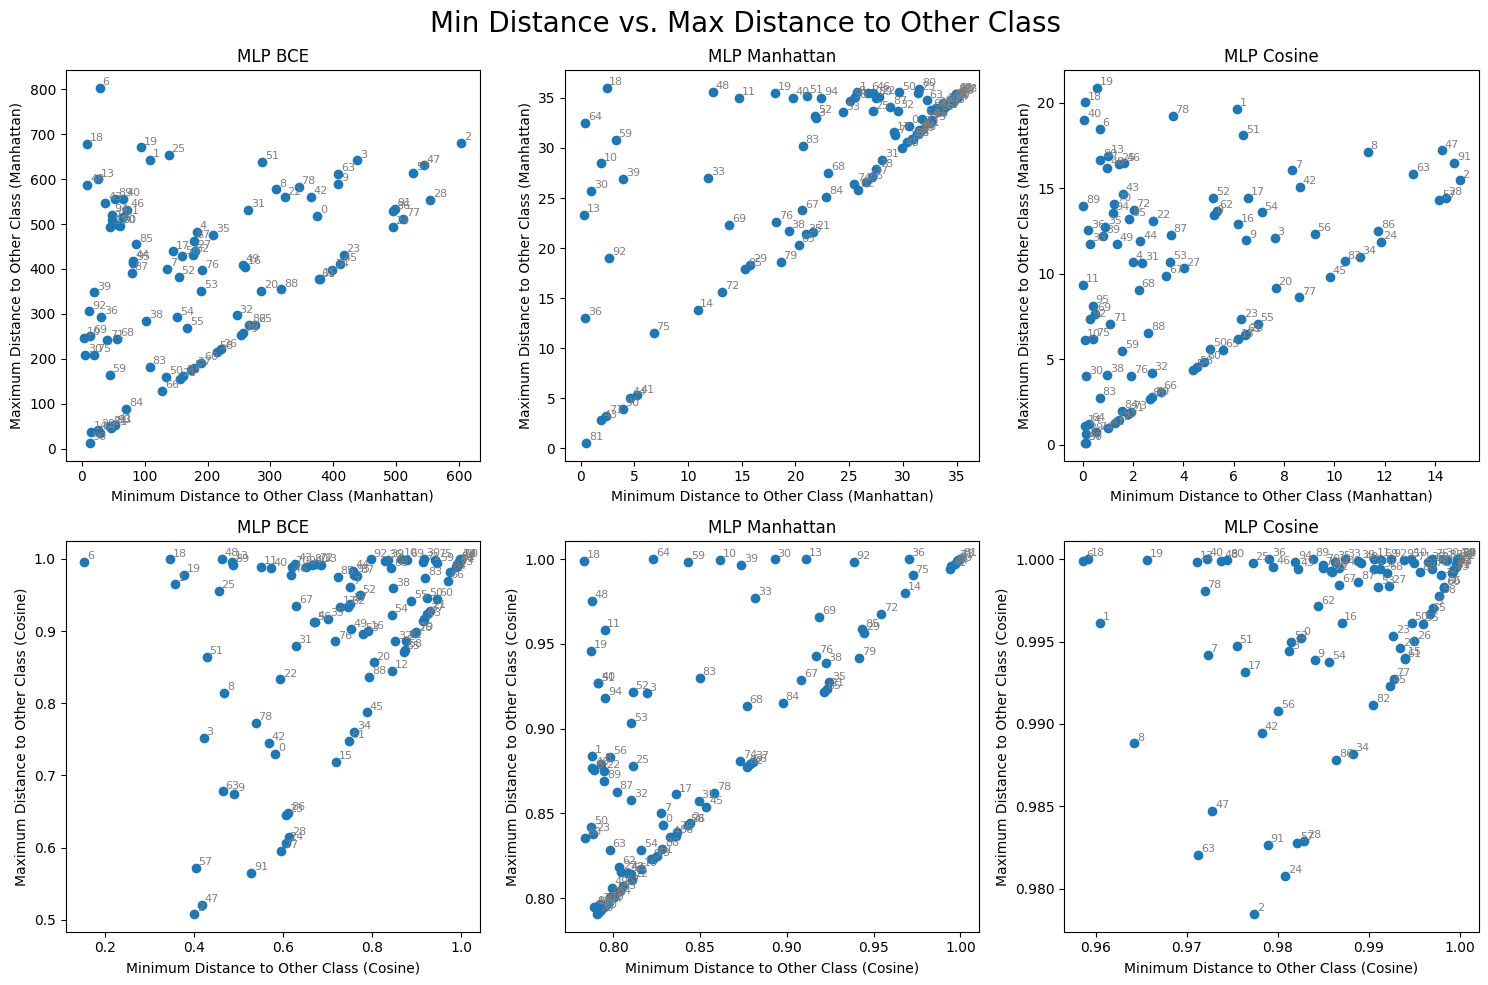

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, network in enumerate(networks):
    axes[0, i].scatter(data[i, :, 4], data[i, :, 5])
    axes[0, i].set_title(network_titles[i])
    axes[0, i].set_xlabel("Minimum Distance to Other Class (Manhattan)")
    axes[0, i].set_ylabel("Maximum Distance to Other Class (Manhattan)")

    for j in range(data.shape[1]):
        axes[0, i].annotate(
            str(j),  
            (data[i, j, 4], data[i, j, 5]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=8,
            color="grey"
        )

    axes[1, i].scatter(data[i, :, 6], data[i, :, 7])
    axes[1, i].set_title(network_titles[i])
    axes[1, i].set_xlabel("Minimum Distance to Other Class (Cosine)")
    axes[1, i].set_ylabel("Maximum Distance to Other Class (Cosine)")

    for j in range(data.shape[1]):
        axes[1, i].annotate(
            str(j),  
            (data[i, j, 6], data[i, j, 7]),  # position of annotation
            textcoords="offset points",  # offset the text
            xytext=(2, 2),  # offset by 2 
            fontsize=8,
            color="grey"
        )

fig.suptitle("Min Distance vs. Max Distance to Other Class", fontsize=20)

plt.tight_layout()
plt.show()

In [11]:
def plot_pca(group_id):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    class_colors = {0: 'blue', 1: 'red'}

    for i, network in enumerate(networks):

        filtered_df = df_train[df_train["cliff_group"] == group_id]

        network.eval()
        dataset = MoleculeACEDataset(filtered_df["ecfp"].apply(str_to_array), filtered_df['active'])
        data_loader = DataLoader(dataset, batch_size=len(filtered_df))

        samples, targets = next(iter(data_loader))
        assert len(samples) == len(filtered_df)

        outputs, emb = network(samples)

        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(emb.detach().numpy())
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(data_scaled)

        colors = filtered_df["active"].map(class_colors)

        axes[i].scatter(principal_components[:, 0], principal_components[:, 1], c=colors)
        axes[i].set_title(network_titles[i])
        axes[i].set_xlabel("PC1")
        axes[i].set_ylabel("PC2")

    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[0], markersize=10, label='Inactive'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[1], markersize=10, label='Active')
    ]
    fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    fig.suptitle(f"PCA of Network Embeddings for Cliff Group {group_id}", fontsize=20)

    plt.tight_layout()
    plt.show()

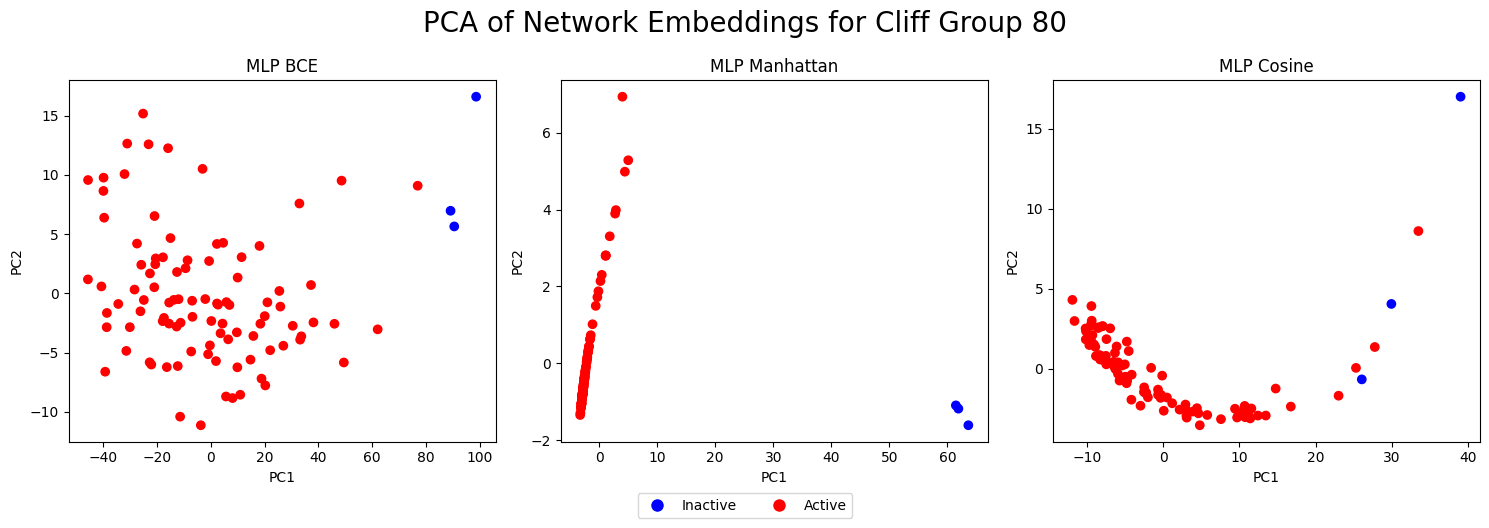

In [12]:
plot_pca(group_id=80)

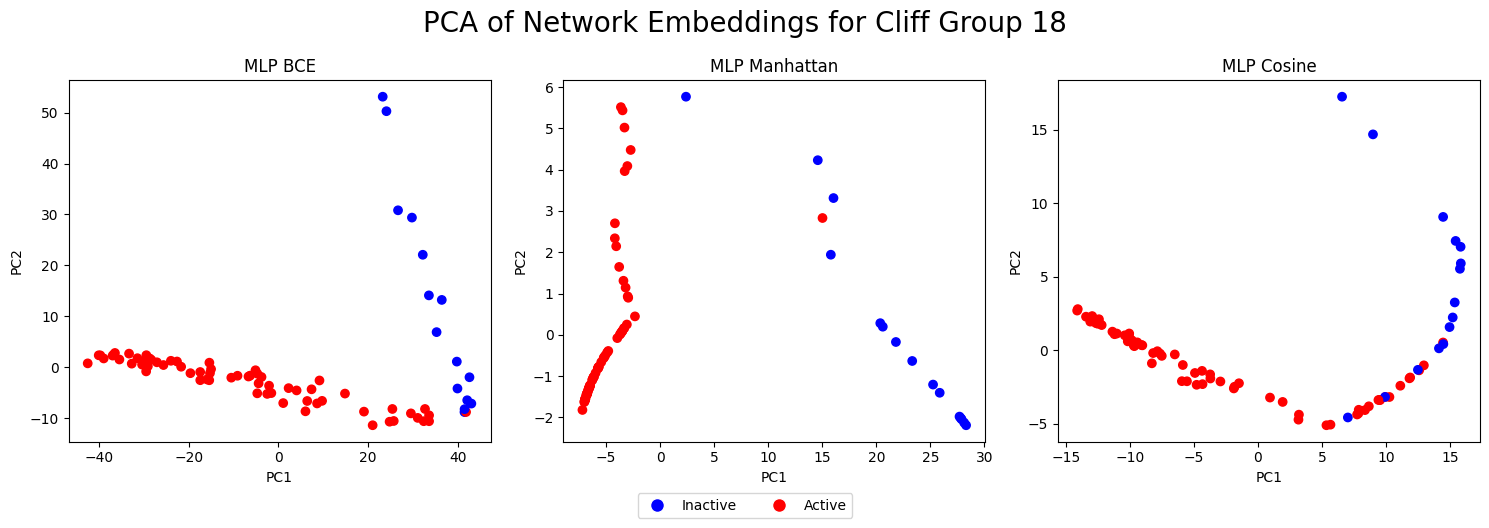

In [13]:
plot_pca(group_id=18)

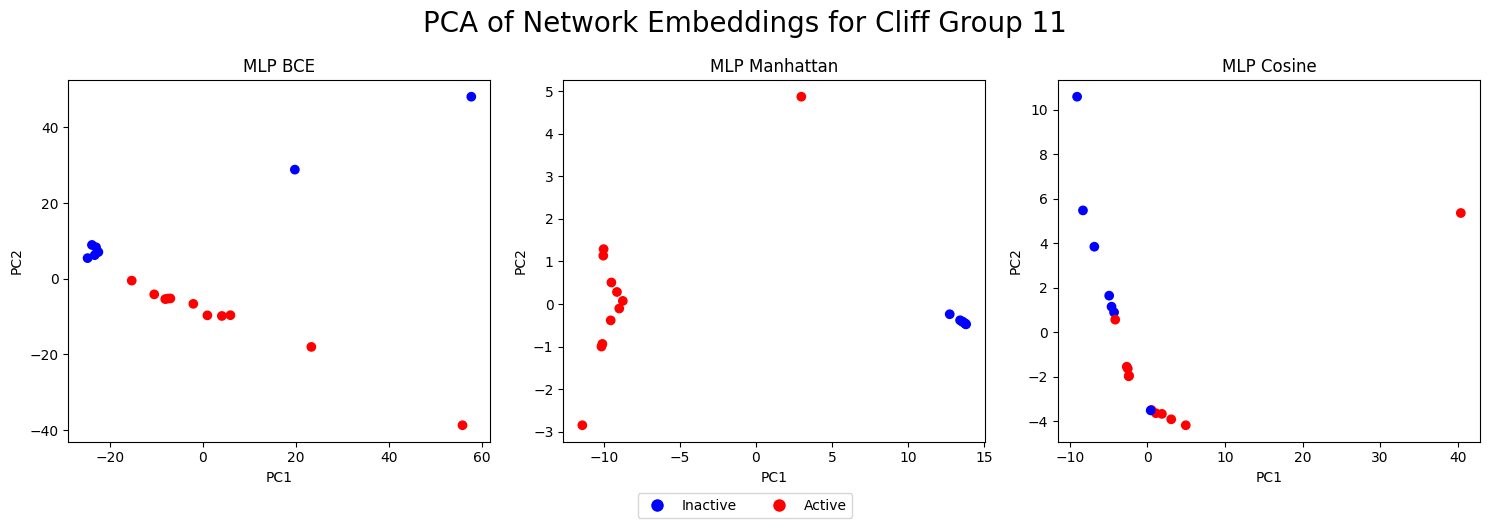

In [14]:
plot_pca(group_id=11)

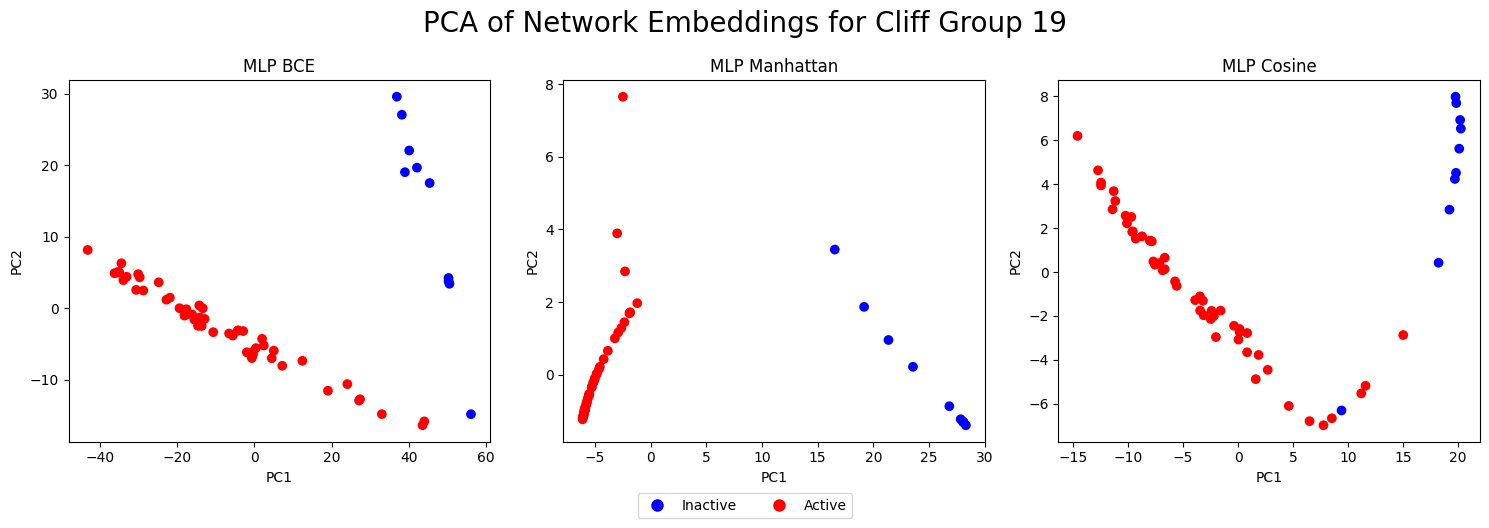

In [15]:
plot_pca(group_id=19)

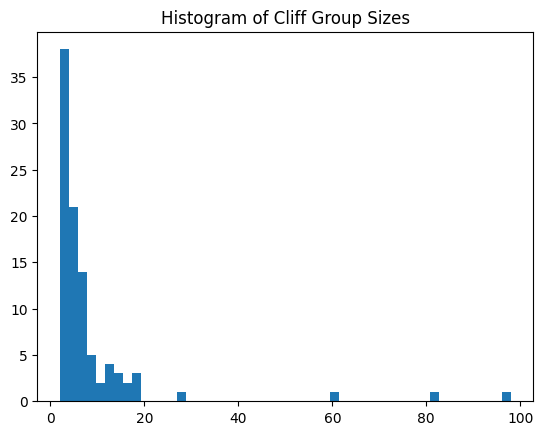

In [16]:
plt.hist(data[0, :, 3], bins=50)
plt.title("Histogram of Cliff Group Sizes")
plt.show()